In [1]:
import intake
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ocean_model_skill_assessor as omsa
import cf_pandas as cfp
import cmocean.cm as cmo
import cf_xarray as cfx

import re
cfp.criteria.guess_regex["longitude"] = re.compile("(?i)x?(?=.*lon)[a-z0-9]*")
cfp.criteria.guess_regex["latitude"] = re.compile("(?i)x?(?=.*lat)[a-z0-9]*")

# cfx.criteria.regex["longitude"] = regex.Regex("(?i)x?(?=.*lon)[a-z0-9]*")
# cfx.criteria.regex["longitude"] = re.compile("(?i)x?(?=.*lon)[a-z0-9]*")
# cfx.criteria.regex["latitude"] = re.compile("(?i)x?(?=.*lat)[a-z0-9]*")

In [24]:
cfx.accessor.regex["longitude"]

re.compile(r'(?i)x?(?=.*lon)[a-z0-9]*', re.IGNORECASE|re.UNICODE)

In [ ]:
cfx.accessor.gu

In [18]:
cfx.criteria.regex["longitude"]

regex.Regex('(?i)x?(?=.*lon)[a-z0-9]*', flags=regex.I | regex.V0)

In [4]:
import regex
lon = regex.Regex("(?i)x?(?=.*lon)[a-z0-9]*")
lon

regex.Regex('(?i)x?(?=.*lon)[a-z0-9]*', flags=regex.I | regex.V0)

In [6]:
lon.match("LON")

<regex.Match object; span=(0, 3), match='LON'>

In [6]:
cfx.criteria.regex["longitude"]

re.compile(r'(?i)x?(?=.*lon)[a-z0-9]*', re.IGNORECASE|re.UNICODE)

# Vocab for variable identification

In [2]:
vocab = cfp.Vocab()

# Make an entry to add to your vocabulary
reg = cfp.Reg(include="tem", ignore_case=True)
vocab.make_entry("temp", reg.pattern(), attr="name")
reg = cfp.Reg(include="sal", ignore_case=True)
vocab.make_entry("salt", reg.pattern(), attr="name")
vocab.make_entry("speed", ["speed"], attr="name")
vocab.make_entry("dir", ["dir"], attr="name")

cfp.set_options(custom_criteria=vocab.vocab)
cfx.set_options(custom_criteria=vocab.vocab)

vocab

{'temp': {'name': '(?i)(?=.*tem)'}, 'salt': {'name': '(?i)(?=.*sal)'}, 'speed': {'name': 'speed'}, 'dir': {'name': 'dir'}}

# Read in datasets

Get to the point of having catalogs for datasets and a basic plot to show the type. I will set up the catalogs for all available years in case the simulation is run past 2018. Need to have:
* datetimes already interpreted, with times
* depth
* catalog
* plot
* longitude in -180 to 180

In [ ]:
cat = intake.open_axds_cat(datatype="platform2", bbox=(-156.5, 56.5, -148.5, 61.5), search_for="Long-term Monitoring of Marine Conditions and Injured Resources")

## CTD

### DONE - CTD profiles 2012-2021 - GWA

https://gulf-of-alaska.portal.aoos.org/#metadata/4e28304c-22a1-4976-8881-7289776e4173/project/files

Project Data > Archive / Annual CTD data files, 2012-ongoing > links are listed below as `urls`. You can find what look like the same datasets with a call to `intake.open_axds_cat`, but it looks like less-curated datasets which do not have labeled transects, which would be harder to use in practice, so we will use the curated datasets.

```
cat = intake.open_axds_cat(datatype="platform2", search_for=["Kachemak","Kachemak Bay CTD"], query_type="intersection")
```

Below is plotted a single transect over all the available times just to demo one variable, but these will need to be split up by transect for the ultimate comparison.

In [30]:
urls = ["https://workspace.aoos.org/published/file/fb5057ac-0c59-42cf-bf35-efbb38089ee9/CookInletKachemakBay_CTD_2012.csv",
        "https://workspace.aoos.org/published/file/476d2d43-02b2-48ef-8a74-5b6ab1f0eee0/CookInletKachemakBay_CTD_2013.csv",
        "https://workspace.aoos.org/published/file/1a5d6c6c-7f5a-4277-8107-84906a05f60b/CookInletKachemakBay_CTD_2014.csv",
        "https://workspace.aoos.org/published/file/09fbcf0e-7f69-4d1a-a152-798134b16a93/CookInletKachemakBay_CTD_2015.csv",
        "https://workspace.aoos.org/published/file/3c574a94-b352-4f80-8025-0162643a9fed/CookInletKachemakBay_CTD_2016.csv",
        "https://workspace.aoos.org/published/file/9694df98-9f53-4754-839f-89a8905b4360/CookInletKachemakBay_CTD_2017.csv",
        "https://workspace.aoos.org/published/file/f0702df6-c57e-4b79-bb71-02aad49f95c7/CookInletKachemakBay_CTD_2018.csv",
        "https://workspace.aoos.org/published/file/7b956e3a-0be4-4a43-af1f-36694027a321/CookInletKachemakBay_CTD_2019.csv",
        "https://workspace.aoos.org/published/file/8d870168-43ae-4825-a7d6-5b13282814a8/CookInletKachemakBay_CTD_2020.csv",
        "https://workspace.aoos.org/published/file/83a85c3c-8b83-4cc4-a5ee-ccaa00107252/CookInletKachemakBay_CTD_2021.csv",
        "https://workspace.aoos.org/published/file/582f3a27-04b3-4e03-940f-9122f83fd6bc/CookInletKachemakBay_CTD_2022.csv"]
cols = ["Date", "Time", "Latitude_DD", "Longitude_DD", "Transect", "StationN", "Bottom.Depth", "Depth", 'Temperature_ITS90_DegC', 'Salinity_PSU']
# df = pd.read_csv(urls[0], header=1, usecols=cols, dtype={'Transect': 'object'}, parse_dates=[["Date","Time"]])
# df
cat = omsa.main.make_local_catalog(
    urls,
    name = "ctd_profiles_gwa",
    description = "CTD profiles 2012-2021 - GWA",
    # metadata: dict = None,
    # metadata_catalog: dict = None,
    skip_entry_metadata=True,
    kwargs_open=dict(header=1, usecols=cols, dtype={'Transect': 'object', 'Bottom.Depth': 'float64'}, parse_dates=[["Date","Time"]]),
)

# dfs = []
# for source_name in list(cat):
#     dfs.append(cat[source_name].read())
# df = pd.concat(dfs)
# df

source_name = list(cat)[0]
df = cat[source_name].read()
df

,Date_Time,Latitude_DD,Longitude_DD,Transect,StationN,Bottom.Depth,Depth,Temperature_ITS90_DegC,Salinity_PSU
0,2012-07-29 20:35:00,60.007,-152.5670,3,S_1,24.0,1,11.1138,27.7043
1,2012-07-29 20:35:00,60.007,-152.5670,3,S_1,24.0,2,10.7355,28.9460
2,2012-07-29 20:35:00,60.007,-152.5670,3,S_1,24.0,3,10.6825,29.0094
3,2012-07-29 20:35:00,60.007,-152.5670,3,S_1,24.0,4,10.6248,29.1623
4,2012-07-29 20:35:00,60.007,-152.5670,3,S_1,24.0,5,10.5223,29.3028
...,...,...,...,...,...,...,...,...,...
35077,2012-10-29 20:53:00,59.596,-151.4038,9,S_10,62.0,42,7.6955,31.0728
35078,2012-10-29 20:53:00,59.596,-151.4038,9,S_10,62.0,43,7.6839,31.0710
35079,2012-10-29 20:53:00,59.596,-151.4038,9,S_10,62.0,44,7.6896,31.0829
35080,2012-10-29 20:53:00,59.596,-151.4038,9,S_10,62.0,45,7.7049,31.0909


In [37]:
df.cf["temp"]

0        11.1138
1        10.7355
2        10.6825
3        10.6248
4        10.5223
          ...   
35077     7.6955
35078     7.6839
35079     7.6896
35080     7.7049
35081     7.7180
Name: Temperature_ITS90_DegC, Length: 35082, dtype: float64

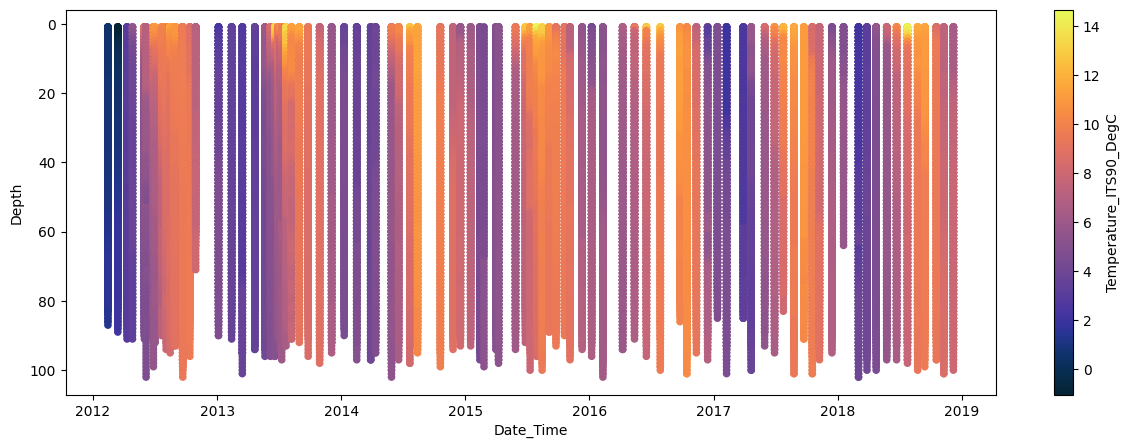

In [109]:
transects = list(set(df["Transect"]))
itransect = df["Transect"] == transects[0]
ax = df.loc[itransect,:].plot.scatter(x="Date_Time", y="Depth", c="Temperature_ITS90_DegC", figsize=(15,5), cmap=cmo.thermal)
ax.invert_yaxis()

### DONE CTD Towed 2017-2019 - GWA

https://gulf-of-alaska.portal.aoos.org/#metadata/87f56b09-2c7d-4373-944e-94de748b6d4b/project/files

Some of these datasets have longitude referenced to "East" but without negative signs. Some to "west" but with negative signs. Will need to force all longitudes to be negative.
The 2017 dataset has no times, so cannot be used. 2019 and 2020 have no depths but don't know if it is at the surface!

According to the [report](https://workspace.aoos.org/published/file/c077e48d-420b-453b-b0b3-5389c9b7a55c/CPR%20Processing%20Steps.pdf?source=catalog&portalId=8) the nominal depth is about 7m, so we will assume that for 2019 and 2020.

In [20]:
urls = ["https://workspace.aoos.org/published/file/38e0b312-74f7-4b0d-aeaa-77bc451eb51f/CPR_physical_data_2017.csv",
        "https://workspace.aoos.org/published/file/a58fd5f1-fc56-4bcb-9fac-8006cc610a9a/CPR_physical_data_2018.csv",
        "https://workspace.aoos.org/published/file/9be9b538-1b51-44a8-9f50-b2db2562adaa/CPR_physical_data_2019.csv",
        "https://workspace.aoos.org/published/file/14a9999c-d952-47ee-ad29-aeb6fa66b1d6/CPR_physical_data_2020.csv"]

slug = "ctd_towed_gwa"
desc = "CTD Towed 2017-2019 - GWA"

cat = \
f'''
name: {slug}
description: 

sources:
  {slug}_2018_base:
    description: Base for {slug}_2018
    driver: csv
    args:
      urlpath: {urls[1]}
      csv_kwargs:
        parse_dates:
          - 0

  {slug}_2018:
    description: {desc} - 2018
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_2018_base
      transform: "process.multiply_longitude_n1"
      transform_kwargs: {{}}

  {slug}_2019_base:
    description: Base for {slug}_2019
    metadata:
      depth: 7
    driver: csv
    args:
      urlpath: {urls[2]}

  {slug}_2019:
    description: {desc} - 2019
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_2019_base
      transform: "process.{slug}_2019"
      transform_kwargs: {{}}

  {slug}_2020_base:
    description: Base for {slug}_2020
    metadata:
      depth: 7
    driver: csv
    args:
      urlpath: {urls[3]}
      csv_kwargs:
        parse_dates:
          - 0

  {slug}_2020:
    description: {desc} - 2020
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_2020_base
      transform: "process.add_depth_column"
      transform_kwargs:
        depth: 7
'''

catname = f"../catalogs/ctd_towed_gwa.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

['ctd_towed_gwa_2018_base',
 'ctd_towed_gwa_2018',
 'ctd_towed_gwa_2019_base',
 'ctd_towed_gwa_2019',
 'ctd_towed_gwa_2020_base',
 'ctd_towed_gwa_2020']

In [21]:
df = cat["ctd_towed_gwa_2018"].read()
df.cf["T"]

0      2018-04-14 03:42:00
1      2018-04-14 03:44:00
2      2018-04-14 03:46:00
3      2018-04-14 03:48:00
4      2018-04-14 03:50:00
               ...        
8766   2018-10-22 17:50:00
8767   2018-10-22 17:55:00
8768   2018-10-22 18:00:00
8769   2018-10-22 18:05:00
8770   2018-10-22 18:10:00
Name: date_dd_mm_yyyy_hh_mm, Length: 8771, dtype: datetime64[ns]

In [22]:
df

,date_dd_mm_yyyy_hh_mm,latitude_degN,longitude_degE,temp_C,chlorophyll_a_fluorescence,depth_m,salinity_ppt
0,2018-04-14 03:42:00,48.26,-123.68,9.75,0.02,0.09,0.01
1,2018-04-14 03:44:00,48.26,-123.70,9.81,0.03,0.09,0.01
2,2018-04-14 03:46:00,48.27,-123.71,9.73,0.01,0.09,0.01
3,2018-04-14 03:48:00,48.27,-123.72,9.72,4.29,3.07,27.69
4,2018-04-14 03:50:00,48.27,-123.74,9.63,-0.21,6.65,28.27
...,...,...,...,...,...,...,...
8766,2018-10-22 17:50:00,58.80,-150.50,9.26,NaN,NaN,NaN
8767,2018-10-22 17:55:00,58.81,-150.54,9.16,NaN,NaN,NaN
8768,2018-10-22 18:00:00,58.82,-150.58,9.34,NaN,NaN,NaN
8769,2018-10-22 18:05:00,58.84,-150.63,9.44,NaN,NaN,NaN


<Axes: xlabel='date_dd_mm_yyyy_hh_mm', ylabel='depth_m'>

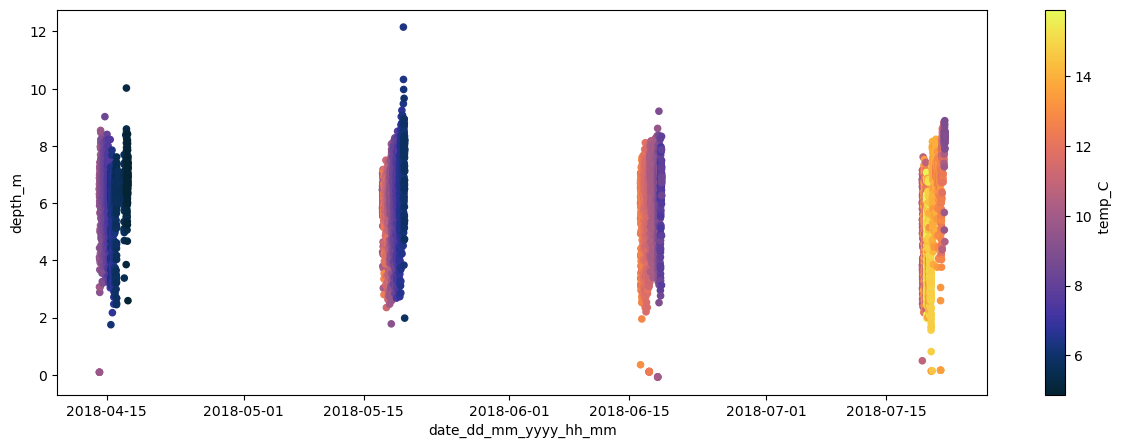

In [23]:
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["temp"][0]
df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.thermal)

### DONE ONLY TIMES FOR 2011 Temperature towed 2011-2016 - GWA

https://gulf-of-alaska.portal.aoos.org/#metadata/87f56b09-2c7d-4373-944e-94de748b6d4b/project/files

MISSING TIMES FOR ALL BUT 2011!!!

The [report](https://workspace.aoos.org/published/file/c077e48d-420b-453b-b0b3-5389c9b7a55c/CPR%20Processing%20Steps.pdf?source=catalog&portalId=8) states a nominal depth of 7m which we will use.

In [3]:
urls = ["https://workspace.aoos.org/published/file/15f607c5-405e-4db8-b83b-0ce70a6015ac/CPR_TemperatureData_2011.csv",
        "https://workspace.aoos.org/published/file/52794d5b-4b85-47f7-9574-927ea2a15fab/CPR_TemperatureData_2012.csv",
        "https://workspace.aoos.org/published/file/bb6469f3-b7f3-4341-9bdc-bf162658dcf2/CPR_TemperatureData_2013.csv",
        "https://workspace.aoos.org/published/file/58c47875-e23d-468b-9fbf-2499f9f54911/CPR_TemperatureData_2014.csv",
        "https://workspace.aoos.org/published/file/fb904438-b909-47c4-8008-6d4815018d53/CPR_TemperatureData_2015.csv",
        "https://workspace.aoos.org/published/file/9a9ad534-145d-4ec2-9cec-5afc3f8659a9/CPR_TemperatureData_2016.csv"]

cat = \
'''
name: temp_towed_gwa
description: 

sources:
  temp_towed_gwa_2011_base:
    description: Base for temp_towed_gwa_2011
    driver: csv
    args:
      urlpath: https://workspace.aoos.org/published/file/15f607c5-405e-4db8-b83b-0ce70a6015ac/CPR_TemperatureData_2011.csv
      csv_kwargs:
        encoding: "ISO-8859-1"

  temp_towed_gwa_2011:
    description: Temperature towed 2011-2016 - GWA - 2011
    driver: process.DataFrameTransform
    metadata:
      depth: 7
    args:
      targets:
        - temp_towed_gwa_2011_base
      transform: "process.temp_towed_gwa"
      transform_kwargs: {}
'''

catname = f"../catalogs/temp_towed_gwa.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
df = cat["temp_towed_gwa_2011"].read()
df.cf["T"]

0      2011-04-16 11:00:00
1      2011-06-18 03:20:00
2      2011-07-21 03:40:00
3      2011-08-20 03:00:00
4      2011-09-22 03:40:00
               ...        
3530   2011-04-19 00:55:00
3531   2011-06-20 17:40:00
3532   2011-07-23 18:00:00
3533   2011-08-22 18:05:00
3534   2011-09-24 18:05:00
Name: date_time, Length: 3535, dtype: datetime64[ns]

In [4]:
df

,Latitude (deg N),Longitude (-ve west),Temp (øC),date_time,depth [m]
0,48.25,-123.55,8.3,2011-04-16 11:00:00,7
1,48.251961,-123.56502,8.8,2011-06-18 03:20:00,7
2,48.26535,-123.60035,16.8,2011-07-21 03:40:00,7
3,48.287048,-123.818714,19.4,2011-08-20 03:00:00,7
4,48.282227,-123.741682,11.5,2011-09-22 03:40:00,7
...,...,...,...,...,...
3530,58.647583,-149.877354,4.7,2011-04-19 00:55:00,7
3531,59.207283,-152.133,6.9,2011-06-20 17:40:00,7
3532,59.028639,-151.44759,9.8,2011-07-23 18:00:00,7
3533,59.154171,-152.047634,11.7,2011-08-22 18:05:00,7


<Axes: xlabel='date_time', ylabel='depth [m]'>

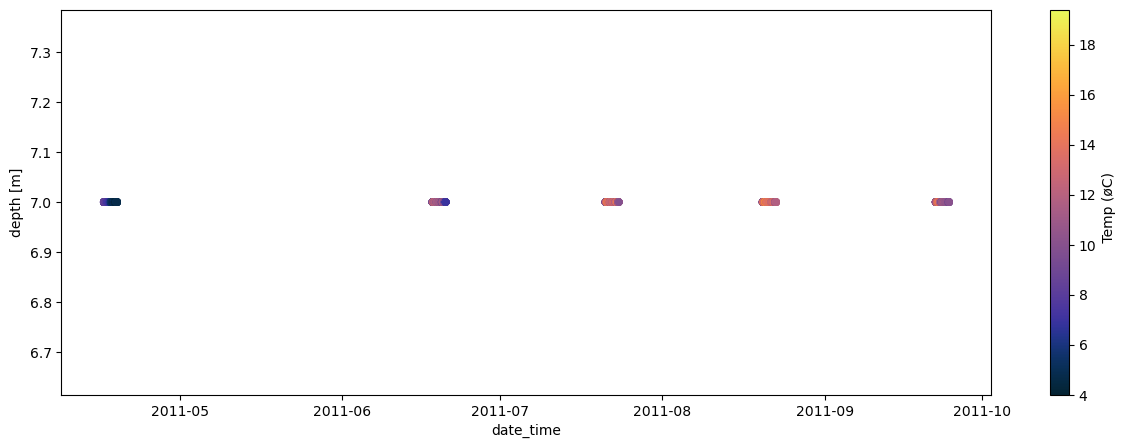

In [5]:
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["temp"][0]
df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.thermal)

### DONE CTD profiles 2005 - NOAA


In [47]:
urls = ["https://researchworkspace.com/files/39886023/noaa_north.txt",
        "https://researchworkspace.com/files/39886022/noaa_south.txt"]
# df = pd.read_csv(urls[1], encoding = "ISO-8859-1", sep="\t", parse_dates={'date_time' : [3, 4]})
# df

cat = omsa.main.make_local_catalog(
    urls,
    name = "ctd_profiles_2005_noaa",
    description = "CTD profiles 2005 - NOAA",
    # metadata: dict = None,
    # metadata_catalog: dict = None,
    skip_entry_metadata=True,
    kwargs_open=dict(encoding = "ISO-8859-1", sep="\t", parse_dates={'date_time' : [3, 4]})
)

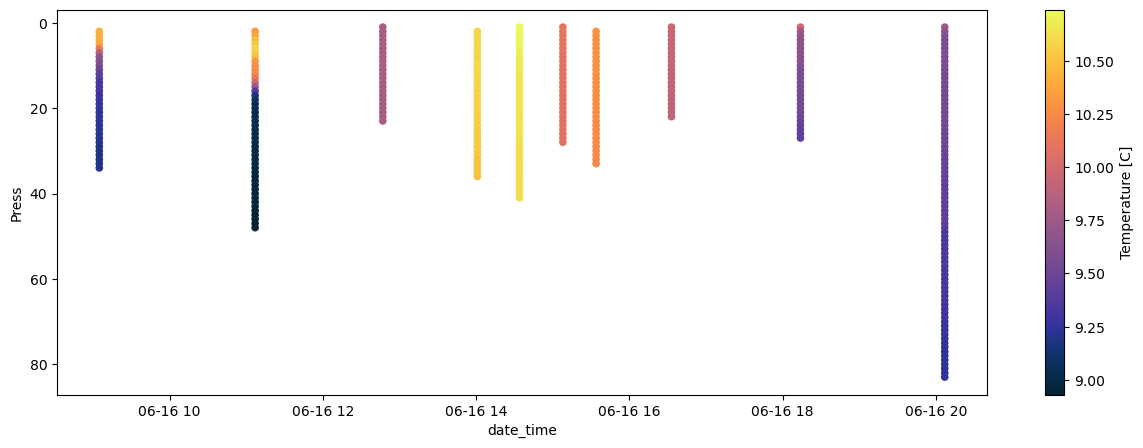

In [49]:
df = cat[list(cat)[0]].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["temp"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.thermal)
ax.invert_yaxis()

### DONE CTD profiles 2003-2006 - OTF KBNERR



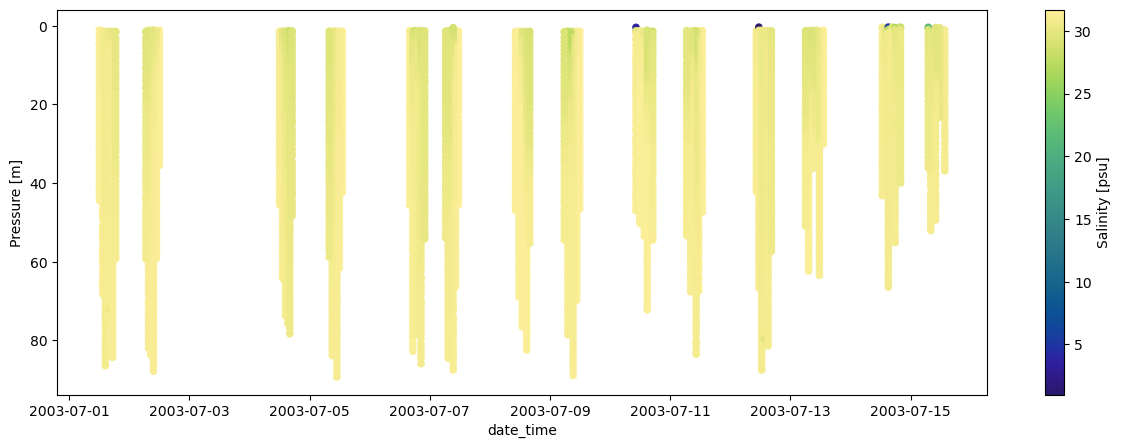

In [53]:
urls = ["https://researchworkspace.com/files/39890736/otf2003_sbe19.txt",
        "https://researchworkspace.com/files/39890793/otf2003_sbe25.txt",
        "https://researchworkspace.com/files/39886054/otf2004.txt",
        "https://researchworkspace.com/files/39886055/otf2005.txt",
        "https://researchworkspace.com/files/39886053/otf2006.txt"]
# df = pd.read_csv(urls[4], encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]})
# df

cat = omsa.main.make_local_catalog(
    urls,
    name = "ctd_profiles_otf_kbnerr",
    description = "CTD profiles 2003-2006 - OTF KBNERR",
    # metadata: dict = None,
    # metadata_catalog: dict = None,
    skip_entry_metadata=True,
    kwargs_open=dict(encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]},
                    dtype={'Depth [m]': 'float64', 'O2 [%sat]': 'float64', 'Station': 'float64'})
)

df = cat[list(cat)[0]].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD profiles 2004-2005 - CMI UAF

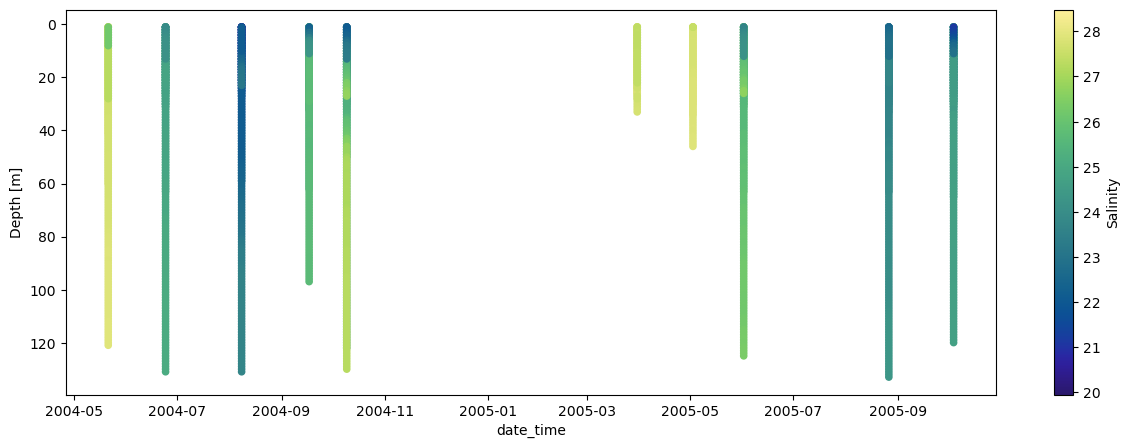

In [18]:
url = "https://researchworkspace.com/files/39886038/all_forelands_ctd.txt"
# df = pd.read_csv(url, sep="\t", dtype={"Month": str, "Year": str, "Day": str, "Hour": str, "Minute": str})
# df["date_time"] = pd.to_datetime(df["Month"].str.zfill(2)+df["Day"].str.zfill(2)+df["Year"]+df["Hour"].str.zfill(2)+df["Minute"].str.zfill(2), format="%m%d%Y%H%M", exact=False)
# df.drop(columns=["Month","Day","Year","Hour","Minute"], inplace=True)

slug = "ctd_profiles_cmi_uaf"

cat = \
f'''
name: {slug}
description: 

sources:
  {slug}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {url}
      csv_kwargs:
        sep: "\t"
        dtype:
          Month: str
          Year: str
          Day: str
          Hour: str
          Minute: str

  {slug}:
    description: CTD profiles 2004-2005 - CMI UAF
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_base
      transform: "process.{slug}"
      transform_kwargs: {{}}
'''

catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

df = cat[slug].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD profiles 2004-2006 - CMI KBNERR

Report: https://researchworkspace.com/file/39885971/2009_041.pdf

![image](https://researchworkspace.com/files/42163411/LCI.png)

/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:624: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:193: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = reader(bio, **kwargs)


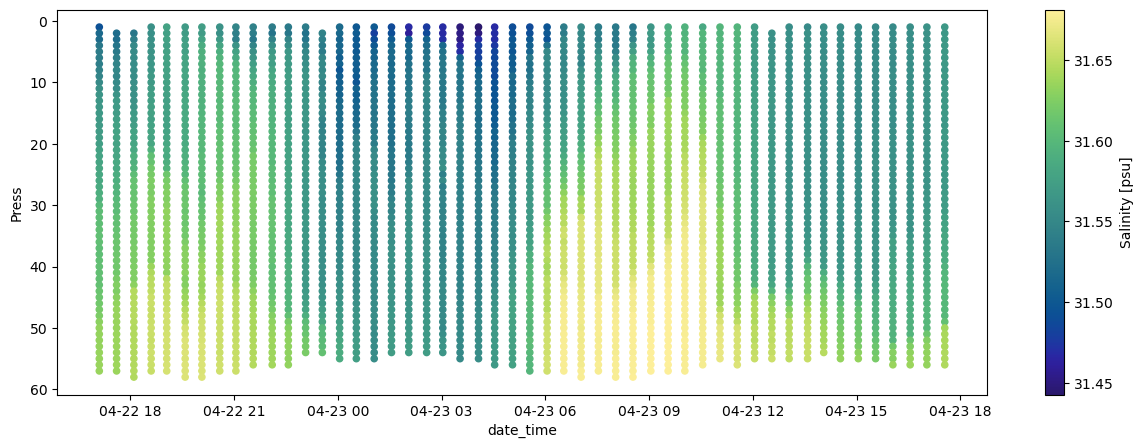

In [32]:
urls = ["https://researchworkspace.com/files/39885976/cmi_full_v2.txt",
        "https://researchworkspace.com/files/39886046/Kbay_timeseries.txt",
        "https://researchworkspace.com/files/39886061/sue_shelikof.txt"]

cols = ['hh:mm', 'mon/day/yr', 'Cruise', 'Station', 'Type', 'Longitude [degrees_east]',
       'Latitude [degrees_north]', 'Bot. Depth [m]', 
       'Temperature [C]', 'Depth [m]', 'Salinity [psu]']
# df = pd.read_csv(urls[0], header=2, sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]}, na_values=-9999.0, usecols=cols)
# df.cf["longitude"] -= 360
# df = pd.read_csv(urls[1], encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm [utc]"]})
# df = pd.read_csv(urls[2], encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]})
# df

slug = "ctd_profiles_cmi_kbnerr"
csv_kwargs = []
csv_kwargs.append(dict(header=2, sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]}, usecols=cols, na_values=-9999.0))
csv_kwargs.append(dict(encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm [utc]"]}))
csv_kwargs.append(dict(encoding = "ISO-8859-1", sep="\t", parse_dates={"date_time": ["mon/day/yr","hh:mm"]}))
names = ["cmi_full_v2", "Kbay_timeseries", "sue_shelikof"]
desc = "CTD profiles 2004-2006 - CMI KBNERR"

cat = \
f'''
name: {slug}
description: {desc}

sources:
  {slug}-{names[0]}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {urls[0]}
      csv_kwargs: {csv_kwargs[0]}

  {slug}-{names[0]}:
    description: {desc}, {names[0]}
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_base
      transform: "process.subtract_360_from_longitude"
      transform_kwargs: {{}}

  {slug}-{names[1]}:
    description: {desc}, {names[1]}
    driver: csv
    args:
      urlpath: {urls[1]}
      csv_kwargs: {csv_kwargs[1]}

  {slug}-{names[2]}:
    description: {desc}, {names[2]}
    driver: csv
    args:
      urlpath: {urls[2]}
      csv_kwargs: {csv_kwargs[2]}
'''

catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

df = cat[list(cat)[2]].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD profiles - USGS BOEM

Report: https://www.usgs.gov/centers/alaska-science-center/science/cook-inlet-seabird-and-forage-fish-study#overview



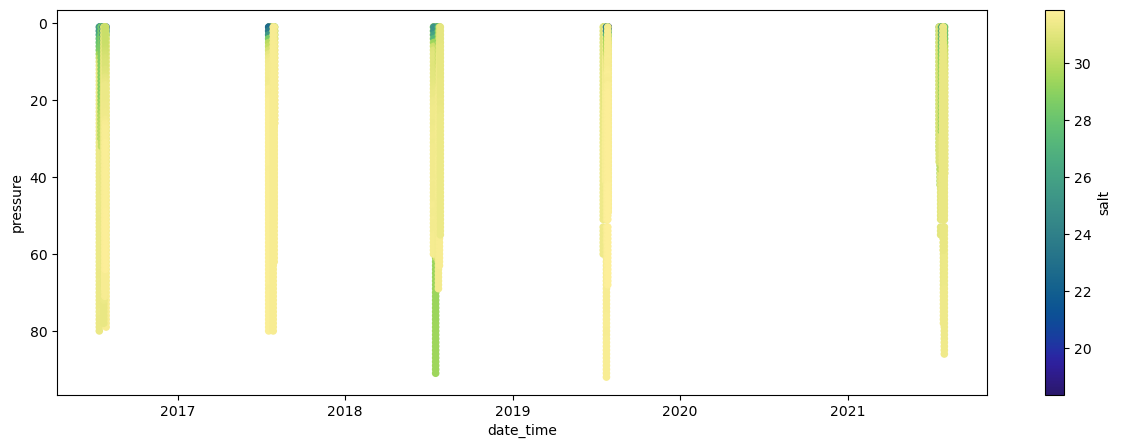

In [9]:
url = "https://researchworkspace.com/files/41842273/Arimitsu_CookInlet_CTD.csv"
cols = ["date","ctd_time [local]", 'station_number', 'location', 'ctd_latitude',
       'ctd_longitude', 'PrdM', 'Tv290C', 'Sal00']
# df = pd.read_csv(url, usecols=cols)#, parse_dates={"date_time": ["date","ctd_time [local]"]})
# df.rename(columns={'PrdM': "pressure", 'Tv290C': "temp", 'Sal00': "salt"}, inplace=True)
# # inds = ["nan" in dt for dt in df["date_time"]]
# inds = df.index[df["ctd_time [local]"].isnull()]
# df = df.drop(index=df.index[inds]).reset_index(drop=True)
# df["date_time"] = pd.to_datetime(df["date"] + " " + df["ctd_time [local]"])
# df.drop(columns=["date","ctd_time [local]"], inplace=True)
# df

slug = "ctd_profiles_usgs_boem"
csv_kwargs = dict(usecols=cols)
desc = "CTD profiles - USGS BOEM"

cat = \
f'''
name: {slug}
description: {desc}

sources:
  {slug}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {url}
      csv_kwargs: {csv_kwargs}

  {slug}:
    description: {desc}
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_base
      transform: "process.ctd_profiles_usgs_boem"
      transform_kwargs: {{}}
'''

catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

df = cat[slug].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD Moored 2006 - CIRCAC

Liz found this helpful information:
* Central Cook Inlet Mooring
* central Cook Inlet (60° 45.7’N, 151° 30.3’W)

/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:624: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:193: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = reader(bio, **kwargs)


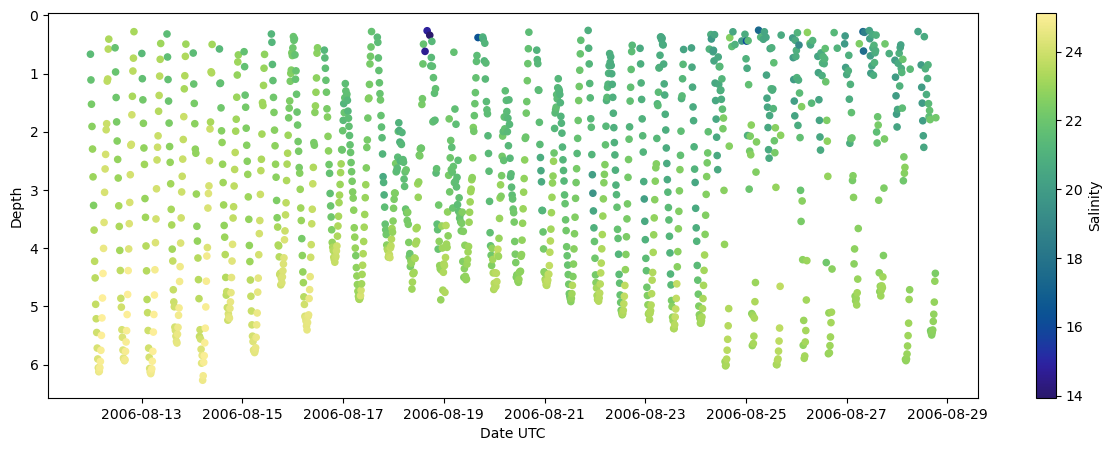

In [8]:
url = "https://researchworkspace.com/files/39886029/xto_mooring_2006.txt"
# df = pd.read_csv(url, sep="\t", parse_dates=True)

slug = "ctd_moored_circac"
csv_kwargs = dict(sep="\t", parse_dates=["Date UTC"])
desc = "CTD Moored 2006 - CIRCAC"
function_name = "add_location_columns"

cat = \
f'''
name: {slug}
description: {desc}

sources:
  {slug}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {url}
      csv_kwargs: {csv_kwargs}

  {slug}:
    description: {desc}
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}_base
      transform: "process.{function_name}"
      transform_kwargs:
        lon: {-(151 + 30.3/60)}
        lat: {60 + 45.7/60}
'''

catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

df = cat[slug].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD Moored 2006-2008 - KBNERR

Liz info:
* Lower Cook Inlet Mooring
* just west of Kennedy Entrance (59° 12.161N 151° 50.860W) very close to shore

/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:624: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/dask/dataframe/io/csv.py:193: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = reader(bio, **kwargs)


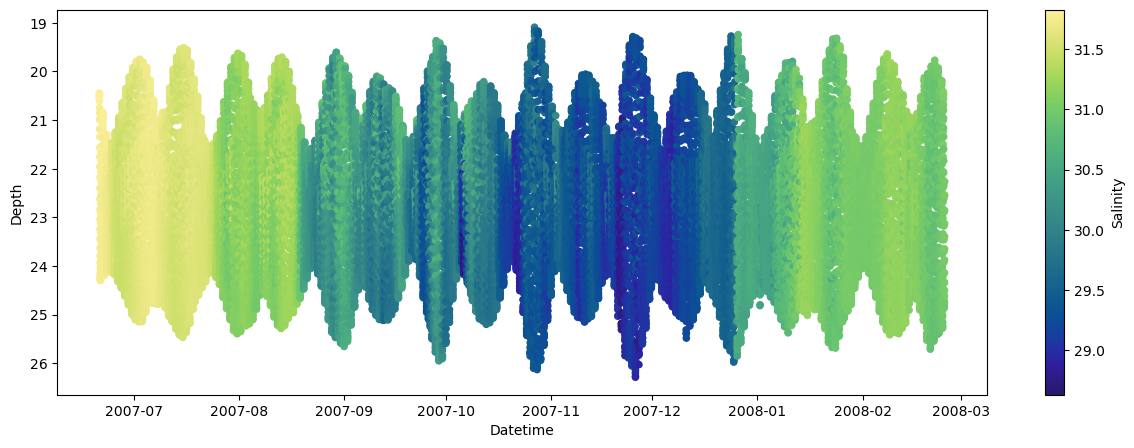

In [26]:
urls = ["https://researchworkspace.com/files/39886044/chrome_bay_mooring_deployment_1.txt",
        "https://researchworkspace.com/files/39886045/chrome_bay_mooring_deployment_2.txt"]
# df = pd.read_csv(urls[0], sep="\t", parse_dates=["Date-time"])
# df = pd.read_csv(urls[1], sep="\t", parse_dates=["Datetime"])
# df

slug = "ctd_moored_kbnerr"
csv_kwargs = []
csv_kwargs.append(dict(sep="\t", parse_dates=["Date-time"]))
csv_kwargs.append(dict(sep="\t", parse_dates=["Datetime"]))
names = ["1", "2"]
desc = "CTD Moored 2006-2008 - KBNERR"
function_name = "add_location_columns"

cat = \
f'''
name: {slug}
description: {desc}

sources:
  {slug}-{names[0]}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {urls[0]}
      csv_kwargs: {csv_kwargs[0]}

  {slug}-{names[0]}:
    description: {desc}
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}-{names[0]}_base
      transform: "process.{function_name}"
      transform_kwargs:
        lon: {-(151 + 50.860/60)}
        lat: {59 + 12.161/60}

  {slug}-{names[1]}_base:
    description: Base for {slug}
    driver: csv
    args:
      urlpath: {urls[1]}
      csv_kwargs: {csv_kwargs[1]}

  {slug}-{names[1]}:
    description: {desc}
    driver: process.DataFrameTransform
    args:
      targets:
        - {slug}-{names[1]}_base
      transform: "process.{function_name}"
      transform_kwargs:
        lon: {-(151 + 50.860/60)}
        lat: {59 + 12.161/60}
'''

catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
list(cat)

df = cat[slug+'-2'].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD time series UAF

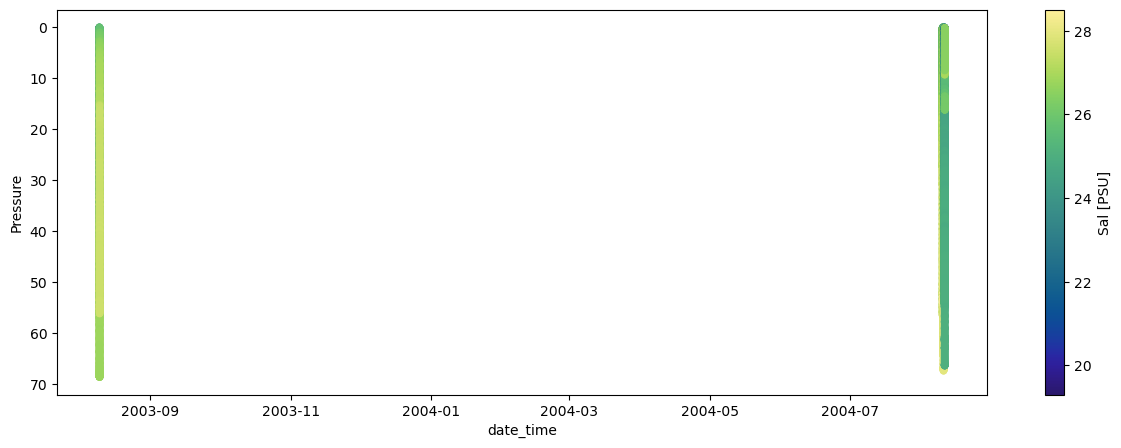

In [43]:
urls = ["https://researchworkspace.com/files/41842203/TS%20downcasts.txt"]
# df = pd.read_csv(url, sep="\t", parse_dates={"date_time": ["mon/day/yr", "hh:mm [utc]"]})
# df.cf["T"]

cat = omsa.main.make_local_catalog(
    urls,
    name = "ctd_time_series_uaf",
    description = "CTD time series UAF",
    # metadata: dict = None,
    # metadata_catalog: dict = None,
    skip_entry_metadata=True,
    kwargs_open=dict(sep="\t", parse_dates={"date_time": ["mon/day/yr", "hh:mm [utc]"]})
)

list(cat)

df = cat['TS%20downcasts'].read()
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

### DONE CTD Towed 2004-2008 Ferry in-line - NOAA PMEL

Website states that the sampling depth was 4m. Clearly the ferry leaves the relevant geographic area some of the time.

* Archive: https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.nodc%3A0070122/html
* report: https://www.nodc.noaa.gov/archive/arc0031/0070122/1.1/data/0-data/Final_Report_NPRB_0707.pdf
* report: https://www.nodc.noaa.gov/archive/arc0031/0070122/1.1/data/0-data/Final_Report_GEM_040699.pdf

![pic](https://www.nodc.noaa.gov/archive/arc0031/0070122/1.1/about/0070122_map.jpg)

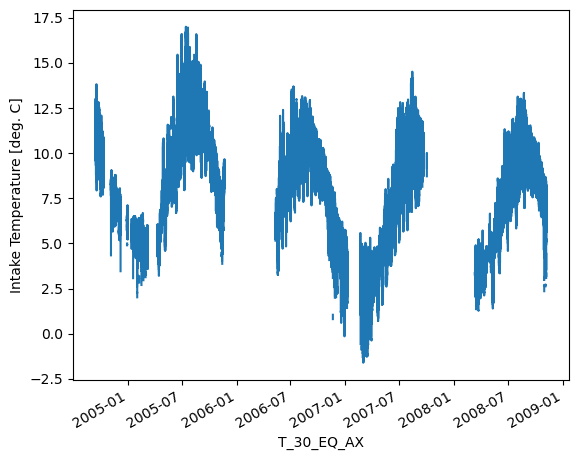

In [14]:
url = "https://www.nodc.noaa.gov/archive/arc0031/0070122/1.1/data/0-data/Tustumena_t_s_chl_cdom_tr_final_data.nc"

slug = "ctd_towed_ferry_noaa_pmel"
# csv_kwargs = []
# csv_kwargs.append(dict(sep="\t", parse_dates=["Date-time"]))
# csv_kwargs.append(dict(sep="\t", parse_dates=["Datetime"]))
# names = ["1", "2"]
desc = "CTD Towed 2004-2008 Ferry in-line - NOAA PMEL"
function_name = slug

cat = \
f'''
name: {slug}
description: {desc}

sources:
  {slug}_base:
    description: Base for {slug}
    driver: netcdf
    args:
      urlpath: {url}

  {slug}:
    description: {desc}
    driver: process.DatasetTransform
    args:
      targets:
        - {slug}_base
      transform: "process.{function_name}"
      transform_kwargs: {{}}
'''
    
catname = f"../catalogs/{slug}.yaml"
file = open(catname,"w")
file.writelines(cat)
file.close()

cat = intake.open_catalog(catname)
ds = cat[slug].read()

ds.cf["temp"].cf.plot()

### NO TIMES surface Temp Sal - OTF ADF&G

Asked Scott

### CTD profiles 1995 - present, Misc

Need to ask Scott.

### CTD profiles 2005 - OSU

might be able to use this, might need to ask Scott questions

In [31]:
urls = ["https://researchworkspace.com/files/39886080/AK060605_001_final_header.txt",
        "https://researchworkspace.com/files/39886081/AK060605_003_final_header.txt",
        "https://researchworkspace.com/files/39886085/AK060605_004_final_header.txt"]
dfs = []
for url in urls:
    dfs.append(pd.read_csv(url, sep="\t"))
# df = pd.read_csv(url, sep="\t")
# df.head(20)
df = pd.concat(dfs, axis=0)
df

,Time(ms),P(dbars),Temp-C,Sal(PSU),Sigma-T,Latitude,Longitude,UTC/GMT_Time,apg400.7,apg405.0,...,bbt_650_VSF,bbt_880_BBLSS,bbpbp_650_VSF,ag_s_exp,ag_s_power,cp_slope,np,PSD_slope_boss,PSD_slope_volz,chl_acs
0,1880.0,0.774,8.90,29.7,23.0,59.6,151.0,0.641,0.646,0.621,...,0.0262,0.0278,0.0237,0.00319,1.61,-0.2960,1.19,-0.258,2.70,5.37
1,3020.0,0.702,8.94,29.7,23.0,59.6,151.0,0.641,0.648,0.636,...,0.0270,0.0271,0.0284,0.00280,1.41,0.2300,1.21,3.100,3.23,4.10
2,4180.0,0.601,8.96,29.6,22.9,59.6,151.0,0.641,0.615,0.612,...,0.0227,0.0274,0.0212,0.00272,1.38,0.3960,1.18,3.350,3.40,2.80
3,5150.0,0.539,9.34,29.2,22.5,59.6,151.0,0.641,0.654,0.649,...,0.0284,0.0323,0.0243,0.00264,1.34,0.0126,1.20,2.550,3.01,2.79
4,6280.0,0.477,9.33,29.2,22.5,59.6,151.0,0.641,0.648,0.628,...,0.0293,0.0323,0.0291,0.00288,1.47,0.4370,1.21,3.400,3.44,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,14000000.0,4.430,9.29,29.7,22.9,59.6,151.0,0.996,0.518,0.512,...,0.0166,0.0191,0.0223,0.00343,1.72,-0.0641,1.19,2.200,2.94,3.86
12902,14000000.0,4.420,9.28,29.7,22.9,59.6,151.0,0.996,0.527,0.496,...,0.0181,0.0179,0.0239,0.00335,1.68,-0.1030,1.20,1.970,2.90,4.13
12903,14000000.0,4.410,9.27,29.7,23.0,59.6,151.0,0.996,0.519,0.514,...,0.0161,0.0177,0.0206,0.00348,1.74,-0.2110,1.18,1.020,2.79,3.63
12904,14000000.0,4.410,9.24,29.7,23.0,59.6,151.0,0.996,0.543,0.503,...,0.0169,0.0177,0.0233,0.00359,1.80,-0.1750,1.19,1.390,2.82,3.95


In [33]:
df = pd.concat(dfs, axis=0)
df

,Time(ms),P(dbars),Temp-C,Sal(PSU),Sigma-T,Latitude,Longitude,UTC/GMT_Time,apg400.7,apg405.0,...,bbt_650_VSF,bbt_880_BBLSS,bbpbp_650_VSF,ag_s_exp,ag_s_power,cp_slope,np,PSD_slope_boss,PSD_slope_volz,chl_acs
0,1880.0,0.774,8.90,29.7,23.0,59.6,151.0,0.641,0.646,0.621,...,0.0262,0.0278,0.0237,0.00319,1.61,-0.2960,1.19,-0.258,2.70,5.37
1,3020.0,0.702,8.94,29.7,23.0,59.6,151.0,0.641,0.648,0.636,...,0.0270,0.0271,0.0284,0.00280,1.41,0.2300,1.21,3.100,3.23,4.10
2,4180.0,0.601,8.96,29.6,22.9,59.6,151.0,0.641,0.615,0.612,...,0.0227,0.0274,0.0212,0.00272,1.38,0.3960,1.18,3.350,3.40,2.80
3,5150.0,0.539,9.34,29.2,22.5,59.6,151.0,0.641,0.654,0.649,...,0.0284,0.0323,0.0243,0.00264,1.34,0.0126,1.20,2.550,3.01,2.79
4,6280.0,0.477,9.33,29.2,22.5,59.6,151.0,0.641,0.648,0.628,...,0.0293,0.0323,0.0291,0.00288,1.47,0.4370,1.21,3.400,3.44,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,14000000.0,4.430,9.29,29.7,22.9,59.6,151.0,0.996,0.518,0.512,...,0.0166,0.0191,0.0223,0.00343,1.72,-0.0641,1.19,2.200,2.94,3.86
12902,14000000.0,4.420,9.28,29.7,22.9,59.6,151.0,0.996,0.527,0.496,...,0.0181,0.0179,0.0239,0.00335,1.68,-0.1030,1.20,1.970,2.90,4.13
12903,14000000.0,4.410,9.27,29.7,23.0,59.6,151.0,0.996,0.519,0.514,...,0.0161,0.0177,0.0206,0.00348,1.74,-0.2110,1.18,1.020,2.79,3.63
12904,14000000.0,4.410,9.24,29.7,23.0,59.6,151.0,0.996,0.543,0.503,...,0.0169,0.0177,0.0233,0.00359,1.80,-0.1750,1.19,1.390,2.82,3.95


<Axes: >

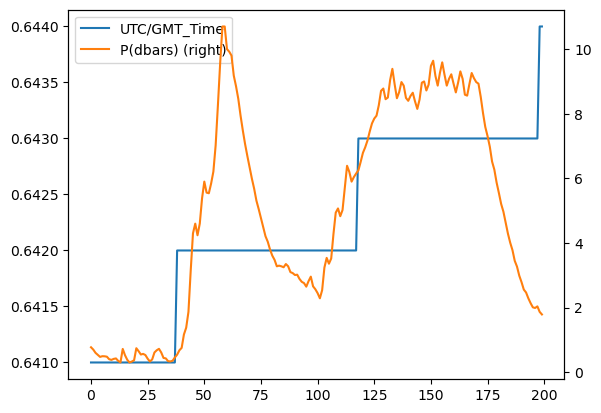

In [49]:
df.reset_index()[["UTC/GMT_Time","P(dbars)"]].iloc[:200].plot(secondary_y="P(dbars)")

<Axes: xlabel='UTC/GMT_Time'>

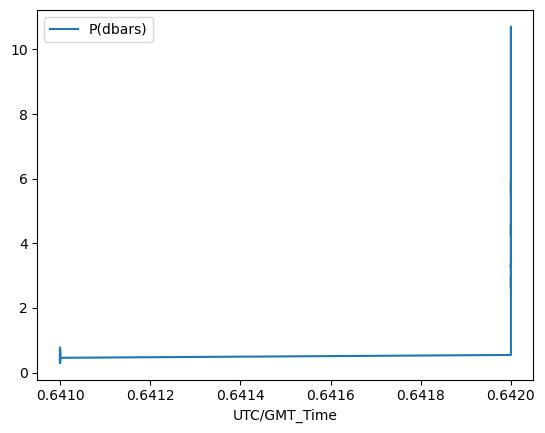

In [48]:
df.reset_index()[["UTC/GMT_Time","P(dbars)"]].iloc[:100].plot(x="UTC/GMT_Time", y="P(dbars)")

<Axes: >

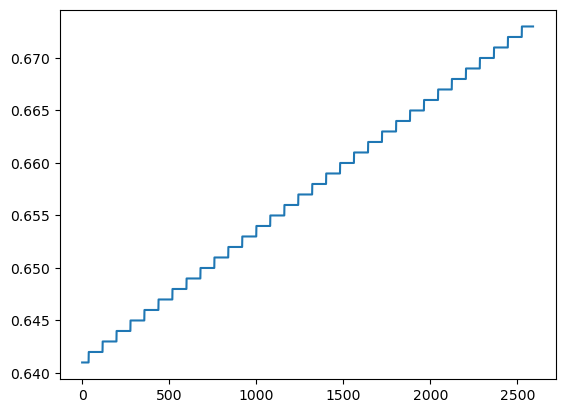

In [37]:
dfs[0]["UTC/GMT_Time"].plot()

<Axes: >

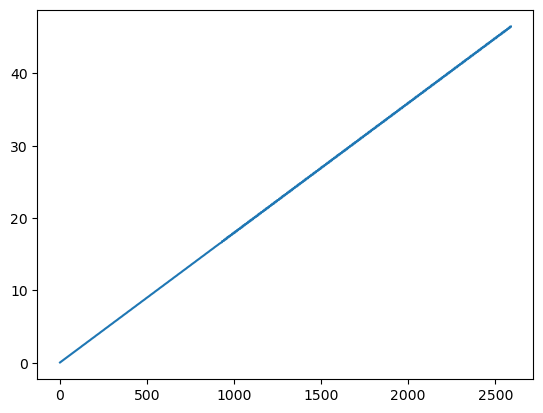

In [34]:
(dfs[0]["Time(ms)"]/1000/60).plot()

<Axes: >

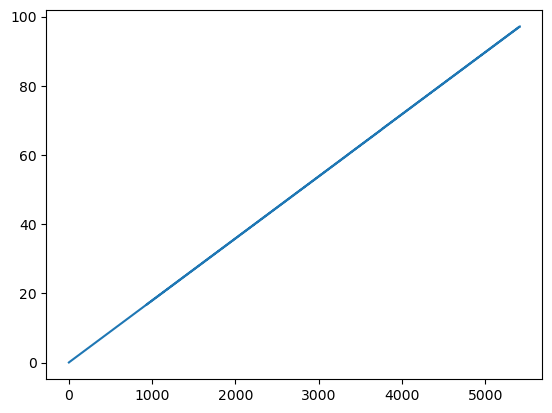

In [35]:
(dfs[1]["Time(ms)"]/1000/60).plot()

<Axes: >

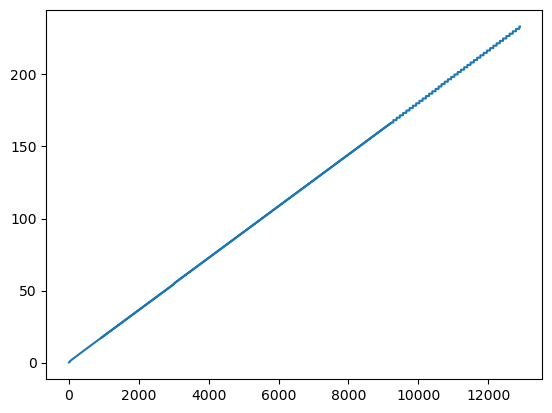

In [36]:
(dfs[2]["Time(ms)"]/1000/60).plot()

<Axes: >

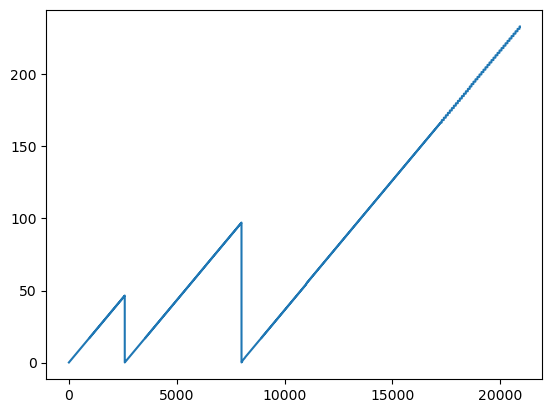

In [42]:
(df.reset_index()["Time(ms)"]/1000/60).plot()

<Axes: >

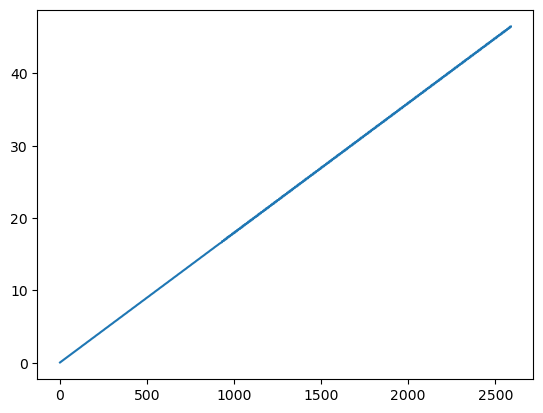

In [29]:
(df["Time(ms)"]/1000/60).plot()

<Axes: >

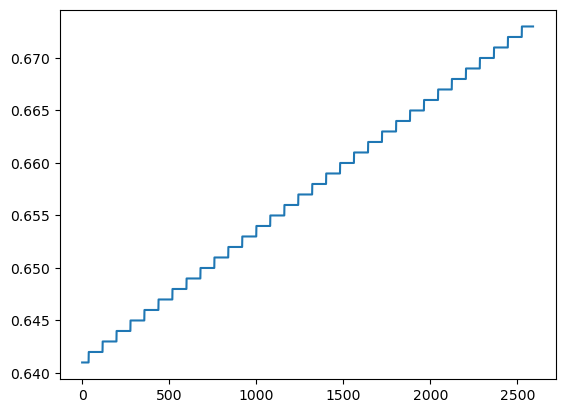

In [26]:
df["UTC/GMT_Time"].plot()

In [21]:
df.columns[:20]

Index(['Time(ms)', 'P(dbars)', 'Temp-C', 'Sal(PSU)', 'Sigma-T', 'Latitude',
       'Longitude', 'UTC/GMT_Time', 'apg400.7', 'apg405.0', 'apg409.4',
       'apg413.9', 'apg418.5', 'apg423.3', 'apg427.9', 'apg432.5', 'apg437.1',
       'apg441.7', 'apg446.2', 'apg450.9'],
      dtype='object')

### CTD Towed 2003 - OTF KBNERR

These look like they will be ok to use.

In [94]:
urls = ["https://researchworkspace.com/files/39891466/mic071203.txt",
        "https://researchworkspace.com/files/39891468/mic071303.txt",
        
        "https://researchworkspace.com/files/39891481/mic072803_4-5.txt"]
df = pd.read_csv(urls[2], sep="\t", parse_dates={"date_time": ['date ', ' time ']}, na_values='      NaN ')
df.columns = df.columns.str.replace(r'\s', '', regex=True)
df = df.dropna(axis=0, subset='lat').reset_index(drop=True)
df

,date_time,yearday,lat,lon,pressure,temperature,salinity,sigma-t
0,2003-07-28 11:33:33,209.481632,59.8208,-152.1911,5.463,11.608,29.643,22.528
1,2003-07-28 11:33:38,209.481690,59.8210,-152.1914,5.335,11.625,29.628,22.512
2,2003-07-28 11:33:43,209.481748,59.8212,-152.1916,5.347,11.594,29.665,22.547
3,2003-07-28 11:33:48,209.481806,59.8213,-152.1918,5.133,11.590,29.667,22.548
4,2003-07-28 11:33:53,209.481863,59.8215,-152.1920,5.170,11.591,29.668,22.549
...,...,...,...,...,...,...,...,...
348,2003-07-28 12:02:36,209.501806,59.8426,-152.2318,-0.026,13.956,0.007,-0.742
349,2003-07-28 12:02:41,209.501863,59.8426,-152.2318,-0.026,13.921,0.007,-0.737
350,2003-07-28 12:02:46,209.501921,59.8427,-152.2318,-0.026,13.981,0.007,-0.745
351,2003-07-28 12:02:51,209.501979,59.8427,-152.2319,-0.026,13.954,0.007,-0.742


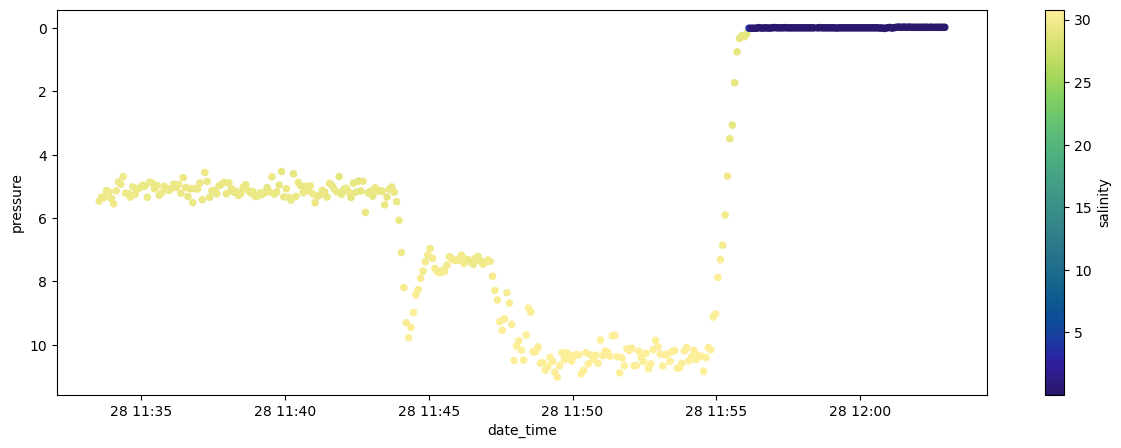

In [95]:
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

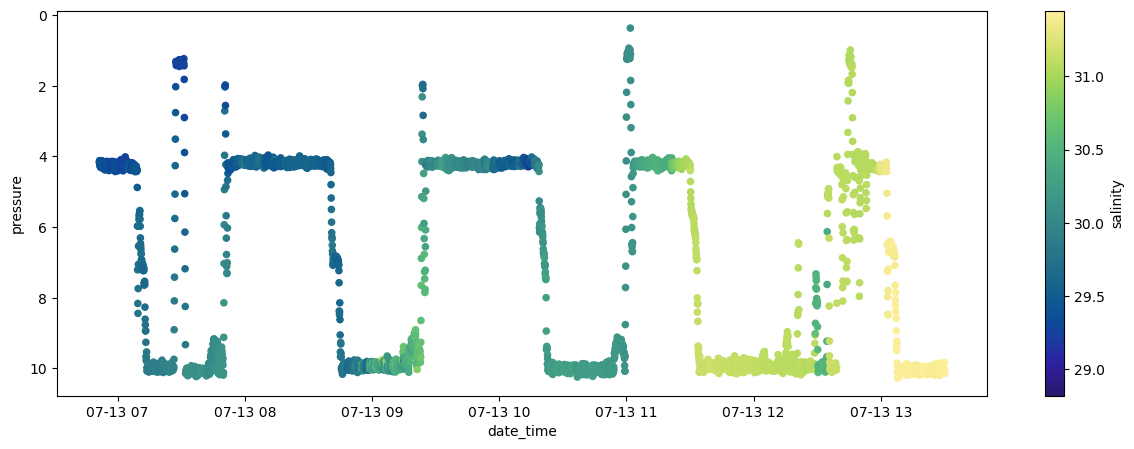

In [93]:
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

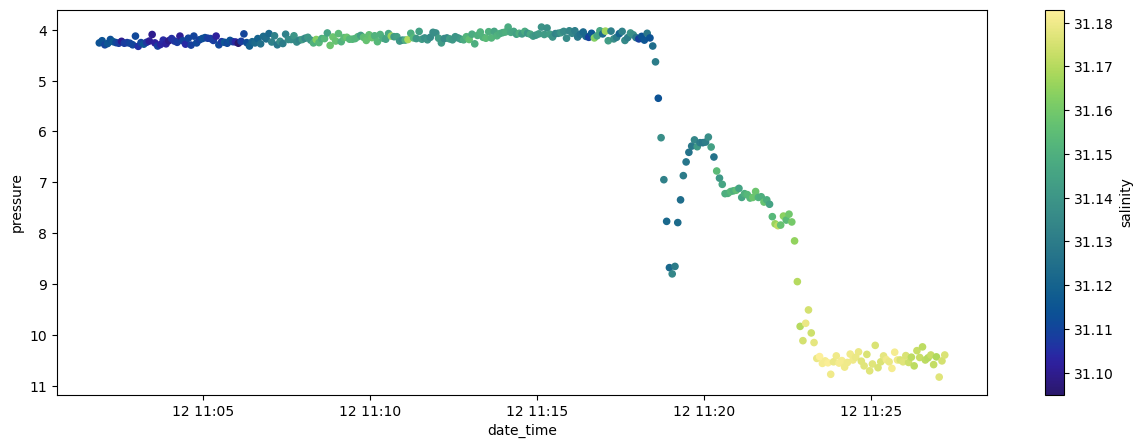

In [89]:
tname, zname, varname = df.cf.axes["T"][0], df.cf.axes["Z"][0], df.cf.custom_keys["salt"][0]
ax = df.plot.scatter(x=tname, y=zname, c=varname, figsize=(15,5), cmap=cmo.haline)
ax.invert_yaxis()

## HF Radar

## Moorings

### CTD moored 2002- present - KBNERR SWMP

Created custom zip file by hand that was emailed to me from http://cdmo.baruch.sc.edu/aqs/

kacbcwq   	Bear Cove                59.70567	151.1094	Inactive  	Jun 2002-Dec 2003
kacdlwq   	Homer Dolphin            59.60232	151.41000	Inactive  	Oct 2002-Dec 2002
kachdwq   	Homer Dolphin Deep       59.60201	151.40878	Active    	Jan 2003-
kachowq   	Homer                    59.60232	151.41000	Inactive  	Jul 2001-Nov 2002
kachswq   	Homer Dolphin Surface    59.60201	151.40878	Inactive  	Feb 2004-Nov 2011
kacpgwq   	Port Graham              59.37053	151.89612	Inactive  	Jun 2002-Sep 2003
kacsdwq   	Seldovia Deep            59.44099	151.72096	Active    	Jan 2004-
kacsewq   	Seldovia                 59.44099	151.72096	Inactive  	Aug 2001-Dec 2003
kacsswq   	Seldovia Surface         59.44099	151.72096	Active    	Jan 2004-
kach3wq   	Homer Surface 3          59.60205	151.40942	Active    	Jun 2012 -

In [98]:
sites = "../data/CTD_KBNERR_301933/sampling_stations.csv"
pd.read_csv(sites)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 301: invalid start byte

In [96]:
loc = "../data/CTD_KBNERR_301933/301933.csv"
df = pd.read_csv(loc, usecols=["StationCode","Temp","Sal","Depth"], low_memory=False)# nrows=5151)
# df.convert_dtypes({"Sal": np.dtype("float")})["Sal"]
df["Sal"] = df["Sal"].astype(float)
df["Sal"]

0          30.7
1          30.5
2          30.8
3          30.7
4          30.9
           ... 
2165731    29.9
2165732    28.0
2165733    30.5
2165734    30.6
2165735    29.9
Name: Sal, Length: 2165736, dtype: float64

## ADCP

* ADCP Moored - NOAA

### ADCP Moored - NOAA

* Station list from RW. Had to change from names from starting with "CO1" to "COI".

In [21]:
station_list = ["COI0206", "COI0207", "COI0213", "COI0301", "COI0302", "COI0303",
                "COI0306", "COI0307", "COI0418", "COI0419", "COI0420", "COI0421",
                "COI0422", "COI0501", "COI0502", "COI0503", "COI0504", "COI0505",
                "COI0506", "COI0507", "COI0508", "COI0509", "COI0510", "COI0511",
                "COI0512", "COI0513", "COI0514", "COI0515", "COI0516", "COI0517",
                "COI0518", "COI0519", "COI0520", "COI0521", "COI0522", "COI0523",
                "COI0524", "COI0801", "COI0802", "COI1201", "COI1202", "COI1203",
                "COI1204", "COI1205", "COI1207", "COI1208", "COI1209", "COI12010"]

Create an Intake catalog with a source for each station. Doesn't read in metadata for each station by default due to the flag `include_source_metadata=False`.

In [22]:
cat = intake.open_coops_cat(station_list, include_source_metadata=False)

/Users/kthyng/miniconda3/envs/ciofs/lib/python3.11/site-packages/attr/_make.py:918: RuntimeWarning: Running interpreter doesn't sufficiently support code object introspection.  Some features like bare super() or accessing __class__ will not work with slotted classes.
  set_closure_cell(cell, cls)


We didn't read it in by default, but you can still access a station's metadata with cat[STATION]._get_dataset_metadata()

In [5]:
cat["COI0213"]._get_dataset_metadata()

{'units': 'metric',
 'flood_direction_degrees': 90.0,
 'orientation': 'up',
 'sensor_depth': None,
 'depth': 23.8,
 'measured_depth': 26.02,
 'height_from_bottom': 9.4,
 'sample_interval': 360,
 'ping_int': None,
 'first_good_data': '2002-07-13 00:00:00.0',
 'last_good_data': '2002-08-14 15:12:00.0',
 'deployments': [{'id': 'COI0213',
   'deployed': '2002-07-12 23:54:00.0',
   'retrieved': '2002-08-14 15:24:00.0',
   'lat': 61.19218,
   'lng': -150.17585,
   'instrument_id': 16184,
   'instrument_desc': 'Workhorse ADCP',
   'real_time_bin': None}],
 'self': 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/COI0213/deployments.json',
 'lat': 61.19218,
 'lon': -150.17585,
 'name': 'Fire Island',
 'observe_dst': True,
 'project': 'Cook Inlet 2002 Current Survey',
 'project_type': 'Survey',
 'timezone_offset': '-9'}

Read one station into Dataset

In [23]:
ds = cat[list(cat)[0]].read()
ds

<xarray.Dataset>
Dimensions:    (date_time: 7850, depth: 13)
Coordinates:
  * date_time  (date_time) datetime64[ns] 2002-07-13T01:06:00 ... 2002-08-14T...
  * depth      (depth) float64 6.71 8.69 10.7 12.71 ... 24.69 26.7 28.71 30.69
Data variables:
    bin        (date_time, depth) float64 13.0 12.0 11.0 10.0 ... 3.0 2.0 1.0
    direction  (date_time, depth) float64 61.0 68.0 82.0 ... 3.0 192.0 191.0
    speed      (date_time, depth) float64 31.3 29.7 33.8 32.0 ... 9.7 7.1 1.7

In [26]:
ds.cf["dir"]

<xarray.DataArray 'direction' (date_time: 7850, depth: 13)>
array([[ 61.,  68.,  82., ..., 110., 109., 112.],
       [ 79.,  81.,  85., ..., 105.,  98.,  93.],
       [ 81.,  83.,  82., ...,  74.,  76.,  71.],
       ...,
       [ 87.,  88.,  89., ..., 158., 162., 158.],
       [ 80.,  87.,  90., ..., 120., 120., 116.],
       [239., 147., 212., ...,   3., 192., 191.]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2002-07-13T01:06:00 ... 2002-08-14T...
  * depth      (depth) float64 6.71 8.69 10.7 12.71 ... 24.69 26.7 28.71 30.69

Plot

In [39]:
u.isel(depth=5)

<xarray.DataArray (date_time: 157)>
array([-6.37012835e-02, -5.28629128e-01, -1.28702448e+00,  1.47105968e+00,
        1.25133754e-01,  5.17413273e-16, -4.61079520e-16, -1.20588781e+00,
        3.46987390e-01, -2.15200550e+00,  1.28896954e+00,  3.01558870e-01,
       -2.60538642e+00,  4.29002314e-01, -4.88295316e-01,  3.07386347e-16,
       -1.91712940e+00, -4.51894669e-16,  7.99320215e-02, -2.09262440e+00,
        5.78960100e-01, -4.57879502e-01, -1.11575723e+00, -7.03955093e-01,
       -1.29715189e+00,  5.95660872e-01, -8.51547720e-02, -1.29428214e+00,
        7.78377327e-02,  1.36859273e+00,  7.52640321e-01, -1.81082409e-01,
       -1.98927131e-01,  5.30249515e-01, -2.56446186e-01, -6.24796150e-02,
        4.34220075e-01, -1.40993967e-01,  1.00883272e+00, -4.29678201e-01,
       -3.43847233e-01,  9.15116021e-01, -1.56791375e+00, -5.91636578e-02,
       -6.58897415e-01, -3.98276627e-01,  2.28348046e-01, -3.57338545e-01,
        2.10026926e-16, -2.68592535e-01,  6.32397203e-01, -1.35232980e+00,
        9.45920429e-02,  3.53306206e-01, -1.75063260e-15, -6.09578182e-01,
       -8.72615343e-01,  1.74266083e+00, -1.07655244e+00,  1.59689519e-01,
       -1.78054515e+00,  1.35605198e-01, -1.61320582e+00, -4.38729636e-01,
        1.02096578e-01,  2.28391367e+00, -1.41678217e+00, -8.12770910e-01,
       -4.28806254e-01, -3.98512753e-01, -3.70015211e-01,  1.37818764e+00,
       -1.10319691e+00,  2.30893928e-01, -5.01145521e-01, -2.35820990e+00,
        2.14721500e+00, -1.37707073e+00, -2.09052264e+00,  3.12969018e-01,
       -5.41099885e-01, -1.39095679e-01,  5.74356345e-01, -2.53652263e-01,
        9.02368671e-01, -5.63164074e-01,  1.73450499e-01,  3.66054120e-01,
       -5.25402662e-01, -1.21163712e+00, -7.73647634e-01,  5.39217542e-01,
        1.53208791e-01, -9.57291265e-01, -1.28599574e+00, -1.21291441e+00,
       -4.29678201e-01, -2.06479162e-01, -4.97818924e-16,  9.91794508e-01,
        9.49101269e-17,  1.96198657e+00,  5.66388352e-01, -2.18307275e-01,
        3.94815515e-01,  8.20138173e-02,  1.57574987e+00, -1.93387484e+00,
       -2.84701011e-01,  1.59761786e+00,  4.06641070e-02, -3.37626936e-01,
        4.14353454e-01, -6.85004293e-01, -2.34163047e+00, -7.87985308e-01,
        1.91208396e+00,  5.13105045e-01, -4.78755467e-01, -4.49929256e-01,
       -2.55308694e-01,  1.77684772e+00,  5.67011468e-16, -2.01107844e+00,
       -4.66670809e-01, -1.28159810e+00, -1.46785654e+00, -7.94416321e-01,
        1.36128770e-01, -3.08259549e+00, -1.00397587e+00, -1.80978085e+00,
        2.98739692e-01, -7.52672352e-01, -1.18309294e-01, -9.40688347e-01,
        1.03872485e+00, -1.86349712e+00,  6.63096566e-01,  8.92551633e-01,
       -1.21280437e+00, -1.31332223e+00, -2.99088687e-01,  3.62605771e-01,
       -6.08037136e-16,  1.22497233e-01, -1.75423023e+00, -8.91627792e-01,
        9.05439029e-01, -1.47088513e+00, -3.51993901e-01,  3.48782369e-01,
        7.84401685e-01,  2.47522346e+00,  1.96484166e-01,  2.51880097e-01,
        4.18538842e-01])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2002-07-13T01:06:00 ... 2002-08-14T...
    depth      float64 16.7

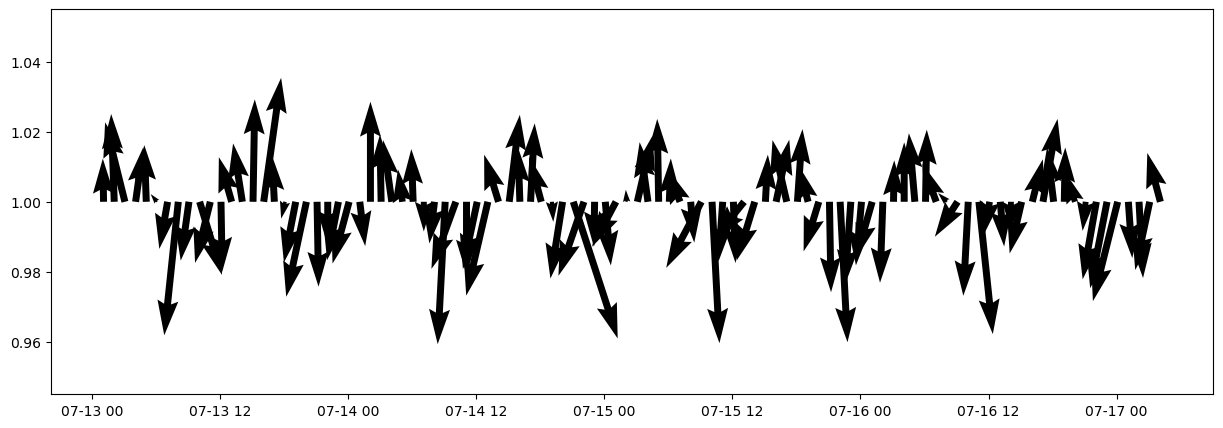

In [43]:
dss = ds.isel(date_time=slice(None,1000,10))
u = np.cos(np.deg2rad(dss["direction"]))*dss["speed"]/10
v = np.sin(np.deg2rad(dss["direction"]))*dss["speed"]/10

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.quiver(dss["date_time"], np.ones(dss["date_time"].shape), u.isel(depth=5), v.isel(depth=5))